In [24]:
import numpy as np
import obspy
import pandas as pd
import os
import matplotlib.pyplot as plt

In [25]:
'''
folder_path = "C:/Users/twitt/BATE/BATE/Michigan/waveforms"
streams = []
# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file has a .mseed extension
    if filename.endswith(".mseed"):
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read the mseed file
            stream = obspy.read(file_path)
            streams.append(stream)
            # Process the stream (example: print basic info)
            print(f"Reading {filename}:")
            print(stream)
            print("------")
            
        except Exception as e:
            print(f"Error reading {filename}: {e}")'
'''

'\nfolder_path = "C:/Users/twitt/BATE/BATE/Michigan/waveforms"\nstreams = []\n# Iterate over all files in the folder\nfor filename in os.listdir(folder_path):\n    # Check if the file has a .mseed extension\n    if filename.endswith(".mseed"):\n        file_path = os.path.join(folder_path, filename)\n        \n        try:\n            # Read the mseed file\n            stream = obspy.read(file_path)\n            streams.append(stream)\n            # Process the stream (example: print basic info)\n            print(f"Reading {filename}:")\n            print(stream)\n            print("------")\n            \n        except Exception as e:\n            print(f"Error reading {filename}: {e}")\'\n'

In [26]:
name = "C:/Users/twitt/BATE/BATE/Michigan"
#st = obspy.read(name + "/waveforms/*.mseed")
st = obspy.read(name + "/waveforms/*.mseed")
inv = obspy.read_inventory(name + "/stations/*.xml")

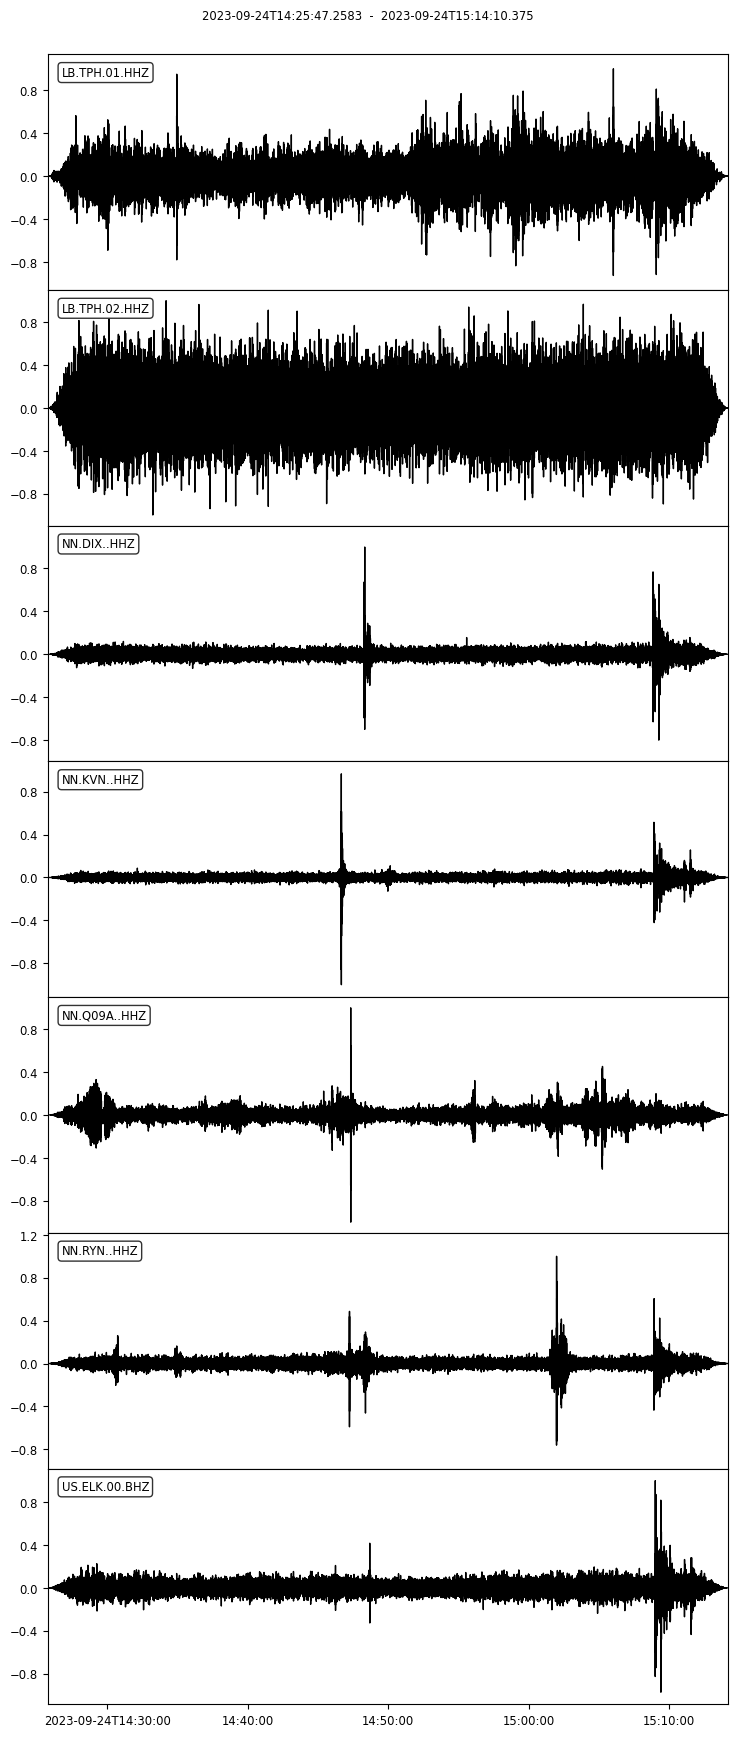

<Figure size 640x480 with 0 Axes>

In [49]:
st.plot()
plt.tight_layout()

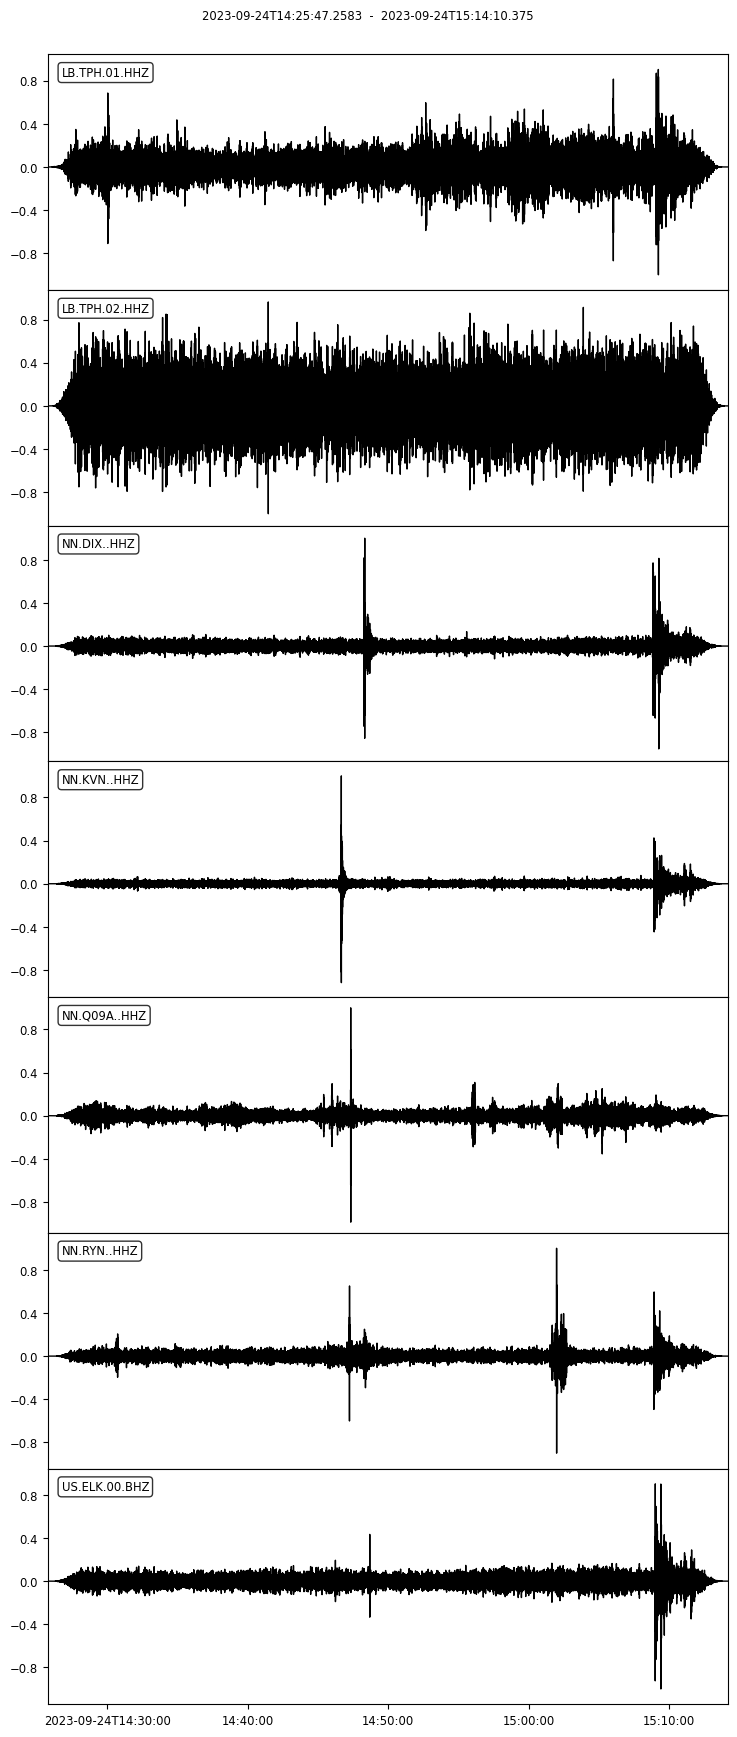

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [50]:
st.merge(fill_value='interpolate')
st.detrend('demean')
st.detrend('linear')
st.resample(10.0)
st.taper(0.05)
for trace in st:
    trace.filter('bandpass', freqmin=1.4,freqmax=4.4, corners = 2, zerophase = True)
    trace.normalize()
st.plot()
plt.tight_layout

In [51]:
time_delay = np.array([])  # Initialize an empty array for time delays
times_not = np.array([])
final_array = np.zeros((len(st),4))
ind = 0
start_time_array = np.zeros(0)
print(start_time_array)
for trace in st:
    times = trace.times()  # Get the time values for the trace
    datetime_times = [trace.stats.starttime + t for t in times]
    data = trace.data  # Get the data from the trace
    data = np.abs(data)  # Take the absolute value of the data
    index = np.argmax(data)  # Find the index of the maximum absolute value
    
    # Append the corresponding time to the time_delay array
    time_delay = np.append(time_delay, datetime_times[index])
    times_not = np.append(times_not, times[index])
    start_time_array = np.append(start_time_array, datetime_times[index])
    final_array[ind,3] = times[index]
    ind += 1


datetimes_as_int = start_time_array.astype('float')

# Calculate the average of the datetime values (in nanoseconds)
average_datetime_int = np.mean(datetimes_as_int)


average_datetime = obspy.UTCDateTime(average_datetime_int)

print(average_datetime)
print(start_time_array)

[]
2023-09-24T14:54:54.720371Z
[UTCDateTime(2023, 9, 24, 15, 9, 13, 363100)
 UTCDateTime(2023, 9, 24, 14, 41, 27, 963100)
 UTCDateTime(2023, 9, 24, 14, 48, 19, 660000)
 UTCDateTime(2023, 9, 24, 14, 46, 39, 663100)
 UTCDateTime(2023, 9, 24, 14, 47, 19, 758300)
 UTCDateTime(2023, 9, 24, 15, 1, 58, 660000)
 UTCDateTime(2023, 9, 24, 15, 9, 23, 975000)]


In [52]:
import folium
import branca
from datetime import datetime

In [53]:
map_center = [42.5, -83.0]  # Adjust to the approximate central coordinates of your stations
mymap = folium.Map(location=map_center, zoom_start=6)  # Adjust zoom_start to your needs
ind = -1

min_value = min(times_not)
max_value = max(times_not)

colormap = branca.colormap.linear.YlOrRd_09.scale(min_value, max_value)

# Add the colorbar to the map
colormap.caption = 'time_delay'
colormap.add_to(mymap)
for network in inv:
    for station in network:
        for channel in station:
            ind += 1

            # Get latitude and longitude
            latitude = station.latitude
            final_array[ind,0] = latitude
            longitude = station.longitude
            final_array[ind,1] = longitude
            station_code = station.code
            network_code = network.code
            time = times_not[ind]
            final_array[ind,2] = station.elevation
            color = colormap(time)

            # Create a marker for each station
            html = f'''
            <div style="background-color: lightblue; padding: 5px; border-radius: 5px;">
                <strong>Station:</strong> {station_code}<br>
                <strong>Network:</strong> {network_code}<br>
                <strong>Time Delay:</strong> {time}
            </div>
            '''
            popup = folium.Popup(html, max_width=300)
            folium.CircleMarker(
                location=[latitude, longitude],
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=popup,
            ).add_to(mymap)

folium.Marker(
    location = [42.538,-83.481],
    tooltip=f"Epicenter",
    color ='red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6,
    icon=folium.Icon(color='red')
).add_to(mymap)

# Optionally display the map (works in Jupyter notebooks)


In [54]:
mymap

In [11]:
mymap.save("station_locations_map.html")


Text(0.5, 0, 'X-axis')

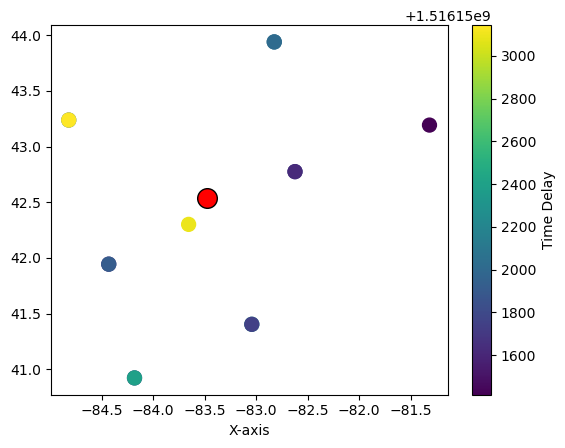

In [33]:
x = []
y = []
for network in inv:
    for station in network:
        for channel in station:
            x += [station.longitude]
            y += [station.latitude]

scatter = plt.scatter(x, y, c=time_delay, cmap='viridis', s=100)

# Add a colorbar to show the mapping of values to colors
plt.colorbar(scatter, label='Time Delay')
plt.scatter(-83.481, 42.538, c='red', s=200, edgecolors='black', label='Epicenter')
# Add labels and title
plt.xlabel('X-axis')

In [35]:
# X,y,azimuth,elevation, time, velocity of fireball

#needs latitude,longtitude, elevation, Initial time of shock (DTCDateTime)
print(final_array)
print(average_datetime)

[[  43.94      -82.8246    217.       1622.4     ]
 [  43.94      -82.8246    217.       1573.3     ]
 [  43.2382    -84.8214    236.       1573.4     ]
 [  43.2382    -84.8214    236.       2701.6     ]
 [  42.7749    -82.6231    191.       1350.6     ]
 [  42.7749    -82.6231    191.       1179.5     ]
 [  41.943802  -84.432899  369.       1221.6     ]
 [  41.943802  -84.432899  369.       1477.2     ]
 [  41.4035    -83.0428    176.       1815.7     ]
 [  41.4035    -83.0428    176.       1305.7     ]
 [  40.922     -84.1825    225.       1303.4     ]
 [  40.922     -84.1825    225.       1951.9     ]
 [  42.3012    -83.6567    172.       2652.5     ]
 [  43.193001  -81.316307  298.        973.      ]]
1622.4
2018-01-17T01:21:03.822929Z


In [14]:
for trace in st:
    # The start time of the trace (first time stamp)
    start_time = trace.stats.starttime
    
    # Print the start time
    print(f"Trace: {trace.id} | First timestamp: {start_time}")

Trace: WU.ELFO..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.I49A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.I49A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.J47A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.J47A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.K50A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.K50A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.L48A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.L48A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.M50A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.M50A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.N49A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.N49A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: US.AAM.00.BHZ | First timestamp: 2018-01-17T00:54:02.275000Z


In [36]:
def get_values(st,inv):
    time_delay = np.array([])  # Initialize an empty array for time delays
    times_not = np.array([])
    final_array = np.zeros((len(st),4))
    ind = 0
    start_time_array = np.zeros(0)
    for trace in st:
        times = trace.times()  # Get the time values for the trace
        datetime_times = [trace.stats.starttime + t for t in times]
        data = trace.data  # Get the data from the trace
        data = np.abs(data)  # Take the absolute value of the data
        index = np.argmax(data)  # Find the index of the maximum absolute value
        
        # Append the corresponding time to the time_delay array
        time_delay = np.append(time_delay, datetime_times[index])
        times_not = np.append(times_not, times[index])
        start_time_array = np.append(start_time_array, datetime_times[index])
        final_array[ind,3] = times[index]
        ind += 1


    datetimes_as_int = start_time_array.astype('float')

    # Calculate the average of the datetime values (in nanoseconds)
    average_datetime_int = np.mean(datetimes_as_int)


    average_datetime = obspy.UTCDateTime(average_datetime_int)
    ind = -1
    for network in inv:
        for station in network:
            for channel in station:
                ind += 1

                # Get latitude and longitude
                latitude = station.latitude
                final_array[ind,0] = latitude
                longitude = station.longitude
                final_array[ind,1] = longitude
                final_array[ind,2] = station.elevation
    
    return final_array, average_datetime

In [47]:
array, time = get_values(st,inv)

In [45]:
def get_data(name):
    st = obspy.read(name + "/waveforms/*.mseed")
    inv = obspy.read_inventory(name + "/stations/*.xml")
    st.merge(fill_value='interpolate')
    st.detrend('demean')
    st.detrend('linear')
    st.resample(10.0)
    st.taper(0.05)
    for trace in st:
        trace.filter('bandpass', freqmin=1.4,freqmax=4.4, corners = 2, zerophase = True)
        trace.normalize()
    
    return st,inv

In [48]:
print(array)
print(time)

[[  38.075    -117.2225   1883.       2413.9     ]
 [  38.075    -117.2225   1883.        504.3     ]
 [  39.8021   -118.083    1143.       1352.4     ]
 [  39.0484   -118.1012   1829.       1252.6     ]
 [  38.834    -117.181602 1703.5      1292.7     ]
 [  38.6281   -118.5223   1651.       2171.4     ]
 [  40.7448   -115.2388   2210.       2592.8     ]]
2023-09-24T14:53:21.563229Z


In [43]:
name = "C:/Users/twitt/BATE/BATE/Nevada"
st, inv = get_data(name)


In [44]:
print(st)

7 Trace(s) in Stream:
LB.TPH.01.HHZ | 2023-09-24T14:25:47.263100Z - 2023-09-24T15:14:10.363100Z | 10.0 Hz, 29032 samples
LB.TPH.02.HHZ | 2023-09-24T14:25:47.263100Z - 2023-09-24T15:14:10.363100Z | 10.0 Hz, 29032 samples
NN.DIX..HHZ   | 2023-09-24T14:25:47.260000Z - 2023-09-24T15:14:10.360000Z | 10.0 Hz, 29032 samples
NN.KVN..HHZ   | 2023-09-24T14:25:47.263100Z - 2023-09-24T15:14:10.363100Z | 10.0 Hz, 29032 samples
NN.Q09A..HHZ  | 2023-09-24T14:25:47.258300Z - 2023-09-24T15:14:10.358300Z | 10.0 Hz, 29032 samples
NN.RYN..HHZ   | 2023-09-24T14:25:47.260000Z - 2023-09-24T15:14:10.360000Z | 10.0 Hz, 29032 samples
US.ELK.00.BHZ | 2023-09-24T14:25:47.275000Z - 2023-09-24T15:14:10.375000Z | 10.0 Hz, 29032 samples


$ \begin{pmatrix}X\\Y\\Z\end{pmatrix} = \begin{pmatrix} cos\gamma sin\theta & sin\gamma sin\theta & -cos\theta \\ -sin\gamma & cos\gamma & 0 \\ cos\gamma cos\theta & sin\gamma cos\theta & sin\theta \end{pmatrix} \begin{pmatrix} x-x_0 \\ y-y_0 \\ z \end{pmatrix}$